<a href="https://colab.research.google.com/github/Hellavn/Machine_Learning_Projects/blob/main/CNN_DatasetMedicalMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Images: [Medical MNIST](https://www.kaggle.com/datasets/yasserh/breast-cancer-dataset/code)


In [75]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [106]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import datasets, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow.keras import backend
from sklearn.model_selection import train_test_split
from pandas._libs.hashtable import value_count
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
import glob

###ETL

In [77]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


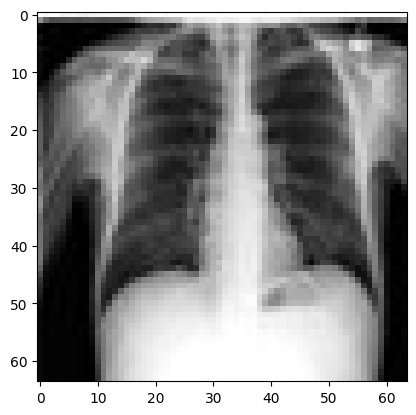

In [78]:
im = plt.imread('/content/drive/MyDrive/CNN_DatasetMedicalMNIST/CXR/000000.jpeg')
plt.imshow(im, 'gray')

In [79]:
files = glob.glob('/content/drive/MyDrive/CNN_DatasetMedicalMNIST/**/*.jpeg', recursive = True)


In [80]:
len(files)

47516

In [81]:
df['path'][0]

'/content/drive/MyDrive/CNN_DatasetMedicalMNIST/AbdomenCT/008917.jpeg'

In [82]:
df = pd.DataFrame({'path':files})

In [83]:
df['class'] = df['path'].apply(lambda x: x.split('/')[5])

In [84]:
df['class'].value_counts()

AbdomenCT    10000
ChestCT      10000
CXR          10000
HeadCT       10000
BreastMRI     3866
Hand          3650
Name: class, dtype: int64

###Definition of architecture

In [85]:
def build_model():

    model = Sequential()

    model.add(layers.Conv2D(filters=32, kernel_size=2, activation="relu", input_shape=(64, 64, 1)))
    model.add(layers.MaxPooling2D(pool_size=2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())

    model.add(layers.Dense(28, activation='relu'))
    model.add(layers.Dense(6, activation='softmax'))

    return model

In [86]:
model = build_model()

In [87]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 63, 63, 32)        160       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 31, 31, 32)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 31, 31, 32)        0         
                                                                 
 flatten_3 (Flatten)         (None, 30752)             0         
                                                                 
 dense_6 (Dense)             (None, 28)                861084    
                                                                 
 dense_7 (Dense)             (None, 6)                 174       
                                                      

In [88]:
x_train, x_test, y_train, y_test = train_test_split(df['path'], df['class'], test_size=0.1)

In [89]:
len(x_train)

42764

In [90]:
len(x_test)

4752

In [91]:
BATCH_SIZE = 128

In [92]:
data_generator = ImageDataGenerator(rotation_range=20, rescale=1./255, validation_split=0.15)

In [93]:
df_train = pd.concat([x_train, y_train], axis=1)

In [94]:
train_generator = data_generator.flow_from_dataframe(dataframe=df_train, x_col='path', y_col='class', class_mode='categorical', batch_size=BATCH_SIZE, target_size=(64,64), subset='training', color_mode='grayscale')

Found 36350 validated image filenames belonging to 6 classes.


In [95]:
validation_generator = data_generator.flow_from_dataframe(dataframe=df_train, x_col='path', y_col='class', class_mode='categorical', batch_size=BATCH_SIZE, target_size=(64,64), subset='validation', color_mode='grayscale')

Found 6414 validated image filenames belonging to 6 classes.


###Compilation

In [96]:
adam = Adam(learning_rate=0.01)
model.compile(loss='categorical_crossentropy',
             optimizer=adam,
             metrics=['accuracy'])

###Training

In [97]:
checkpoint = ModelCheckpoint('medical_image_model.hdf5',
                             monitor='val_loss',
                             verbose=1, mode='min',
                             save_best_only=True)

In [98]:
early_stop = EarlyStopping(monitor='val_loss',
                                   min_delta=0.001,
                                   patience=5,
                                   mode='min',
                                   verbose=1)

In [99]:
model.fit(train_generator, callbacks=[checkpoint, early_stop], steps_per_epoch = train_generator.samples//BATCH_SIZE,
                    validation_data=validation_generator,
                    validation_steps=validation_generator.samples//BATCH_SIZE, epochs=5)

Epoch 1/5
283/283 [==============================] - ETA: 0s - loss: 0.2091 - accuracy: 0.9574 
Epoch 1: val_loss improved from inf to 0.01548, saving model to medical_image_model.hdf5
283/283 [==============================] - 3538s 13s/step - loss: 0.2091 - accuracy: 0.9574 - val_loss: 0.0155 - val_accuracy: 0.9950
Epoch 2/5
283/283 [==============================] - ETA: 0s - loss: 0.0126 - accuracy: 0.9961
Epoch 2: val_loss improved from 0.01548 to 0.01020, saving model to medical_image_model.hdf5
283/283 [==============================] - 112s 395ms/step - loss: 0.0126 - accuracy: 0.9961 - val_loss: 0.0102 - val_accuracy: 0.9967
Epoch 3/5
283/283 [==============================] - ETA: 0s - loss: 0.0313 - accuracy: 0.9922
Epoch 3: val_loss did not improve from 0.01020
283/283 [==============================] - 114s 404ms/step - loss: 0.0313 - accuracy: 0.9922 - val_loss: 0.0306 - val_accuracy: 0.9939
Epoch 4/5
283/283 [==============================] - ETA: 0s - loss: 0.0115 - acc

In [100]:
model

In [101]:
model = load_model('medical_image_model.hdf5')

In [104]:
test_imgs = [img_to_array(load_img(im_path, color_mode = "grayscale")) for im_path in x_test]

In [107]:
y_pred = model.predict(np.array(test_imgs))

149/149 [==============================] - 2s 12ms/step


In [108]:
y_pred.argmax(axis=1)

array([3, 3, 0, ..., 0, 3, 0])

In [109]:
y_test

9762     AbdomenCT
19911      ChestCT
45963    BreastMRI
46232    BreastMRI
2171     AbdomenCT
           ...    
26291          CXR
23937          CXR
44917    BreastMRI
7182     AbdomenCT
35437       HeadCT
Name: class, Length: 4752, dtype: object

In [110]:
le = preprocessing.LabelEncoder()

In [111]:
y_test = le.fit_transform(y_test)

In [112]:
le.classes_

array(['AbdomenCT', 'BreastMRI', 'CXR', 'ChestCT', 'Hand', 'HeadCT'],
      dtype=object)

In [113]:
cm = confusion_matrix(y_test, y_pred.argmax(axis=1))

In [114]:
cm

array([[   0,    0,    0,  955,    0,    0],
       [ 367,    0,    2,   14,    0,    0],
       [   5,    0,  435,  559,    0,    0],
       [   0,    0,    0, 1026,    0,    0],
       [ 265,    0,   15,   90,   12,    0],
       [ 816,    0,    0,  191,    0,    0]])

### Transfer learning test

In [115]:
train_generator = data_generator.flow_from_dataframe(dataframe=df_train, x_col='path', y_col='class', class_mode='categorical', batch_size=BATCH_SIZE, target_size=(64,64), subset='training', color_mode='rgb')
valid_generator = data_generator.flow_from_dataframe(dataframe=df_train, x_col='path', y_col='class', class_mode='categorical', batch_size=BATCH_SIZE, target_size=(64,64), subset='validation', color_mode='rgb')

Found 36350 validated image filenames belonging to 6 classes.
Found 6414 validated image filenames belonging to 6 classes.


In [116]:
def build_model2(shape):
    '''
    Constroi as camadas da rede
    :return: modelo construido
    '''

    base_model = MobileNetV2(weights = "imagenet", include_top=False, input_shape = shape)
    # congelando camadas que não iremos treinar.
    # para congelar alguns layers específicos basta passar o indice: for layer in mobile.layers[:5]:
    for layer in base_model.layers[:3]:
        layer.Trainable=False

    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    predictions = layers.Dense(6, activation='softmax')(x)

    model = Model(base_model.input, predictions)

    return model

In [117]:
model = build_model2((64,64,3))

9406464/9406464 [==============================] - 0s 0us/step


In [118]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 Conv1 (Conv2D)                 (None, 32, 32, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 32, 32, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 32, 32, 32)   0           ['bn_Conv1[0][0]']               
                                                                                              

In [119]:
model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

In [ ]:
model.fit(train_generator, callbacks=[checkpoint, early_stop], steps_per_epoch = train_generator.samples//BATCH_SIZE,
                    validation_data=valid_generator,
                    validation_steps=valid_generator.samples//BATCH_SIZE, epochs=50)

Epoch 1/50
283/283 [==============================] - ETA: 0s - loss: 0.0248 - accuracy: 0.9932
Epoch 1: val_loss did not improve from 0.00882
283/283 [==============================] - 557s 2s/step - loss: 0.0248 - accuracy: 0.9932 - val_loss: 16.2290 - val_accuracy: 0.6497
Epoch 2/50
100/283 [=========>....................] - ETA: 4:46 - loss: 0.0071 - accuracy: 0.9985